## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import LeNet5, LeNet5Dropout, NaimishNet

net = LeNet5Dropout()
print(net)

LeNet5Dropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (dens4): Linear(in_features=15488, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, RandomVFlip, RandomContrastReduction, RandomRot, ToGrayScale, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale((96, 96)), RandomVFlip(0.5), ToGrayScale(), RandomContrastReduction(0.5, 0.8), RandomRot(0.5, 5), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    return validation_batches(1)[0]
        
        
def validation_batches(num_batches=None):
    batches = []
    for i, sample in enumerate(test_loader):
        if i == num_batches:
            return batches
        
        images = sample['image']
        key_pts = sample['keypoints']

        images = images.type(torch.FloatTensor)
        output_pts = net(images)  
        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)        
        batches.append((images, output_pts, key_pts,))
        
    return batches            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 96, 96])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray', vmin=0, vmax=1.0)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

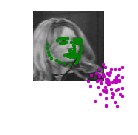

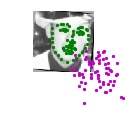

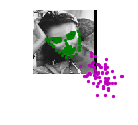

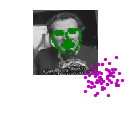

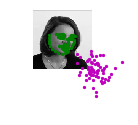

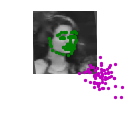

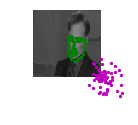

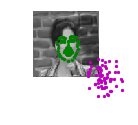

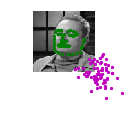

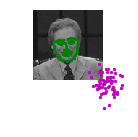

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters())


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def rmse_of_batch(predicted, actual):
    batch_size = len(actual)
    rmse = 0
    for i in range(0, batch_size):
        rmse += rmse_of_vectors(predicted[i].data.numpy(), actual[i].numpy())
    return rmse / batch_size

def rmse_of_vectors(predicted, actual):
    predicted = predicted.flatten()
    actual = actual.flatten()
    return np.sqrt(np.mean((predicted - actual)**2))

In [16]:
def train_net(n_epochs):
    # prepare the net for training
    net.train()
    
    loss_over_time = []
    rmse_train_per_epoch = []
    rmse_valid_per_epoch = []
    
    lowest_error = 1.0
    patience = 30
    epochs_without_improvement = 0
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        last_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts_tensor = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts_tensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss / 10
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0
                
        v_error = validate()       
        
        rmse_train_per_epoch.append(rmse_of_batch(output_pts, key_pts)) 
        rmse_valid_per_epoch.append(v_error)     
        
        if v_error < lowest_error:
            lowest_error = v_error
            epochs_without_improvement = 0
            
            print("Saving currently best model with error: ", lowest_error)
            torch.save(net.state_dict(), 'saved_models/checkpoint.pt')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("Patience limit reached")
            break

    print('Finished Training')
    return loss_over_time, rmse_train_per_epoch, rmse_valid_per_epoch


def validate():
    num_test_batches = 0
    v_error = 0
    for _, test_outputs, gt_pts in validation_batches():
        v_error += rmse_of_batch(test_outputs, gt_pts)
        num_test_batches += 1

    return v_error / num_test_batches


In [17]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

training_loss, t_rmse, v_rmse = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.7077740274369717
Epoch: 1, Batch: 20, Avg. Loss: 0.07696512341499329
Epoch: 1, Batch: 30, Avg. Loss: 0.03666959051042795
Epoch: 1, Batch: 40, Avg. Loss: 0.022964566387236117
Epoch: 1, Batch: 50, Avg. Loss: 0.018895804602652787
Epoch: 1, Batch: 60, Avg. Loss: 0.015896144323050976
Epoch: 1, Batch: 70, Avg. Loss: 0.015372801572084427
Epoch: 1, Batch: 80, Avg. Loss: 0.014360127970576286
Epoch: 1, Batch: 90, Avg. Loss: 0.014425431098788976
Epoch: 1, Batch: 100, Avg. Loss: 0.013467118237167596
Saving currently best model with error:  0.104625823602
Epoch: 2, Batch: 10, Avg. Loss: 0.015761752054095267
Epoch: 2, Batch: 20, Avg. Loss: 0.013195964973419905
Epoch: 2, Batch: 30, Avg. Loss: 0.01417283695191145
Epoch: 2, Batch: 40, Avg. Loss: 0.014018007833510638
Epoch: 2, Batch: 50, Avg. Loss: 0.013127337396144866
Epoch: 2, Batch: 60, Avg. Loss: 0.013040635734796524
Epoch: 2, Batch: 70, Avg. Loss: 0.01196946045383811
Epoch: 2, Batch: 80, Avg. Loss: 0.01418282398954

Epoch: 15, Batch: 60, Avg. Loss: 0.007527339365333318
Epoch: 15, Batch: 70, Avg. Loss: 0.006889979681000113
Epoch: 15, Batch: 80, Avg. Loss: 0.007702423958107829
Epoch: 15, Batch: 90, Avg. Loss: 0.006905960571020842
Epoch: 15, Batch: 100, Avg. Loss: 0.005902077630162239
Epoch: 16, Batch: 10, Avg. Loss: 0.006498485617339611
Epoch: 16, Batch: 20, Avg. Loss: 0.006229154253378511
Epoch: 16, Batch: 30, Avg. Loss: 0.0067273403983563185
Epoch: 16, Batch: 40, Avg. Loss: 0.008101601665839554
Epoch: 16, Batch: 50, Avg. Loss: 0.007713274145498872
Epoch: 16, Batch: 60, Avg. Loss: 0.006944443425163626
Epoch: 16, Batch: 70, Avg. Loss: 0.007495393650606275
Epoch: 16, Batch: 80, Avg. Loss: 0.006842185906134546
Epoch: 16, Batch: 90, Avg. Loss: 0.006250162282958627
Epoch: 16, Batch: 100, Avg. Loss: 0.00638772938400507
Saving currently best model with error:  0.0722248498216
Epoch: 17, Batch: 10, Avg. Loss: 0.0070292922668159005
Epoch: 17, Batch: 20, Avg. Loss: 0.006844741757959127
Epoch: 17, Batch: 30, 

Epoch: 30, Batch: 20, Avg. Loss: 0.005109695577993989
Epoch: 30, Batch: 30, Avg. Loss: 0.004758747736923396
Epoch: 30, Batch: 40, Avg. Loss: 0.004546952131204307
Epoch: 30, Batch: 50, Avg. Loss: 0.004837405122816563
Epoch: 30, Batch: 60, Avg. Loss: 0.005476760072633624
Epoch: 30, Batch: 70, Avg. Loss: 0.005438990937545895
Epoch: 30, Batch: 80, Avg. Loss: 0.00534885791130364
Epoch: 30, Batch: 90, Avg. Loss: 0.005067060142755509
Epoch: 30, Batch: 100, Avg. Loss: 0.00449041563551873
Epoch: 31, Batch: 10, Avg. Loss: 0.005235229851678014
Epoch: 31, Batch: 20, Avg. Loss: 0.004766919207759202
Epoch: 31, Batch: 30, Avg. Loss: 0.00524449092335999
Epoch: 31, Batch: 40, Avg. Loss: 0.004714440950192511
Epoch: 31, Batch: 50, Avg. Loss: 0.0055790204554796215
Epoch: 31, Batch: 60, Avg. Loss: 0.004706146894022822
Epoch: 31, Batch: 70, Avg. Loss: 0.004034506133757531
Epoch: 31, Batch: 80, Avg. Loss: 0.004371082875877619
Epoch: 31, Batch: 90, Avg. Loss: 0.0038590308278799055
Epoch: 31, Batch: 100, Avg. 

Epoch: 44, Batch: 100, Avg. Loss: 0.0033717833925038577
Epoch: 45, Batch: 10, Avg. Loss: 0.0032033486291766166
Epoch: 45, Batch: 20, Avg. Loss: 0.0028521951520815493
Epoch: 45, Batch: 30, Avg. Loss: 0.003230338031426072
Epoch: 45, Batch: 40, Avg. Loss: 0.0031043951399624347
Epoch: 45, Batch: 50, Avg. Loss: 0.0035002519143745303
Epoch: 45, Batch: 60, Avg. Loss: 0.0030592225259169934
Epoch: 45, Batch: 70, Avg. Loss: 0.0032974548172205686
Epoch: 45, Batch: 80, Avg. Loss: 0.003494057711213827
Epoch: 45, Batch: 90, Avg. Loss: 0.0032722611213102937
Epoch: 45, Batch: 100, Avg. Loss: 0.004096967005170882
Saving currently best model with error:  0.052688502752
Epoch: 46, Batch: 10, Avg. Loss: 0.0037141815992072225
Epoch: 46, Batch: 20, Avg. Loss: 0.0037769412621855734
Epoch: 46, Batch: 30, Avg. Loss: 0.0038936672499403358
Epoch: 46, Batch: 40, Avg. Loss: 0.003677488095127046
Epoch: 46, Batch: 50, Avg. Loss: 0.0041809676913544536
Epoch: 46, Batch: 60, Avg. Loss: 0.0030434015206992626
Epoch: 46, 

Epoch: 59, Batch: 70, Avg. Loss: 0.002698120241984725
Epoch: 59, Batch: 80, Avg. Loss: 0.0026104597141966223
Epoch: 59, Batch: 90, Avg. Loss: 0.0032176153501495717
Epoch: 59, Batch: 100, Avg. Loss: 0.0031566246645525096
Epoch: 60, Batch: 10, Avg. Loss: 0.0031553617678582667
Epoch: 60, Batch: 20, Avg. Loss: 0.0027952684788033364
Epoch: 60, Batch: 30, Avg. Loss: 0.002903696638531983
Epoch: 60, Batch: 40, Avg. Loss: 0.002560527774039656
Epoch: 60, Batch: 50, Avg. Loss: 0.002999678300693631
Epoch: 60, Batch: 60, Avg. Loss: 0.0024469519266858697
Epoch: 60, Batch: 70, Avg. Loss: 0.0027217355091124773
Epoch: 60, Batch: 80, Avg. Loss: 0.002460918459109962
Epoch: 60, Batch: 90, Avg. Loss: 0.002656407956965268
Epoch: 60, Batch: 100, Avg. Loss: 0.002754801232367754
Saving currently best model with error:  0.0474205231802
Epoch: 61, Batch: 10, Avg. Loss: 0.0027885315706953407
Epoch: 61, Batch: 20, Avg. Loss: 0.002987187635153532
Epoch: 61, Batch: 30, Avg. Loss: 0.0029137302888557317
Epoch: 61, Bat

Epoch: 74, Batch: 60, Avg. Loss: 0.0026481611654162406
Epoch: 74, Batch: 70, Avg. Loss: 0.0022991754347458484
Epoch: 74, Batch: 80, Avg. Loss: 0.0022861857432872057
Epoch: 74, Batch: 90, Avg. Loss: 0.0023042085696943103
Epoch: 74, Batch: 100, Avg. Loss: 0.00248427449259907
Epoch: 75, Batch: 10, Avg. Loss: 0.0027382897678762674
Epoch: 75, Batch: 20, Avg. Loss: 0.002365509048104286
Epoch: 75, Batch: 30, Avg. Loss: 0.002958983788266778
Epoch: 75, Batch: 40, Avg. Loss: 0.0022521873470395803
Epoch: 75, Batch: 50, Avg. Loss: 0.002362805313896388
Epoch: 75, Batch: 60, Avg. Loss: 0.0023377182893455028
Epoch: 75, Batch: 70, Avg. Loss: 0.0023859567823819815
Epoch: 75, Batch: 80, Avg. Loss: 0.0023405930842272937
Epoch: 75, Batch: 90, Avg. Loss: 0.00226412279298529
Epoch: 75, Batch: 100, Avg. Loss: 0.002444766031112522
Epoch: 76, Batch: 10, Avg. Loss: 0.0024647493846714497
Epoch: 76, Batch: 20, Avg. Loss: 0.0021254804916679857
Epoch: 76, Batch: 30, Avg. Loss: 0.002110079245176166
Epoch: 76, Batch:

Epoch: 89, Batch: 50, Avg. Loss: 0.002628193038981408
Epoch: 89, Batch: 60, Avg. Loss: 0.002587608806788921
Epoch: 89, Batch: 70, Avg. Loss: 0.002290806989185512
Epoch: 89, Batch: 80, Avg. Loss: 0.0020490113296546043
Epoch: 89, Batch: 90, Avg. Loss: 0.0020356565015390514
Epoch: 89, Batch: 100, Avg. Loss: 0.001919073157478124
Epoch: 90, Batch: 10, Avg. Loss: 0.002007827931083739
Epoch: 90, Batch: 20, Avg. Loss: 0.0019053611322306097
Epoch: 90, Batch: 30, Avg. Loss: 0.0018644167459569872
Epoch: 90, Batch: 40, Avg. Loss: 0.0020482872845605017
Epoch: 90, Batch: 50, Avg. Loss: 0.001763759134337306
Epoch: 90, Batch: 60, Avg. Loss: 0.002036935114301741
Epoch: 90, Batch: 70, Avg. Loss: 0.00213606288889423
Epoch: 90, Batch: 80, Avg. Loss: 0.0023255742387846114
Epoch: 90, Batch: 90, Avg. Loss: 0.00262132678180933
Epoch: 90, Batch: 100, Avg. Loss: 0.002164556109346449
Epoch: 91, Batch: 10, Avg. Loss: 0.0022703843656927346
Epoch: 91, Batch: 20, Avg. Loss: 0.0021037930971942844
Epoch: 91, Batch: 30

Epoch: 104, Batch: 20, Avg. Loss: 0.0019809555727988482
Epoch: 104, Batch: 30, Avg. Loss: 0.0019082993385381997
Epoch: 104, Batch: 40, Avg. Loss: 0.0017853247351013123
Epoch: 104, Batch: 50, Avg. Loss: 0.0018813088769093155
Epoch: 104, Batch: 60, Avg. Loss: 0.001920341292861849
Epoch: 104, Batch: 70, Avg. Loss: 0.0018671994330361485
Epoch: 104, Batch: 80, Avg. Loss: 0.002163344109430909
Epoch: 104, Batch: 90, Avg. Loss: 0.001984181487932801
Epoch: 104, Batch: 100, Avg. Loss: 0.0017264383961446584
Epoch: 105, Batch: 10, Avg. Loss: 0.002014940767548978
Epoch: 105, Batch: 20, Avg. Loss: 0.002111080382019281
Epoch: 105, Batch: 30, Avg. Loss: 0.0022204829030670224
Epoch: 105, Batch: 40, Avg. Loss: 0.0018430444761179388
Epoch: 105, Batch: 50, Avg. Loss: 0.0019939398975111545
Epoch: 105, Batch: 60, Avg. Loss: 0.002121455129235983
Epoch: 105, Batch: 70, Avg. Loss: 0.0018016502261161804
Epoch: 105, Batch: 80, Avg. Loss: 0.0018368589109741152
Epoch: 105, Batch: 90, Avg. Loss: 0.00176120760152116

Epoch: 118, Batch: 80, Avg. Loss: 0.0017131544649600984
Epoch: 118, Batch: 90, Avg. Loss: 0.0018249691813252867
Epoch: 118, Batch: 100, Avg. Loss: 0.0018588873324915766
Epoch: 119, Batch: 10, Avg. Loss: 0.002317935798782855
Epoch: 119, Batch: 20, Avg. Loss: 0.0020080490619875492
Epoch: 119, Batch: 30, Avg. Loss: 0.0019465490942820907
Epoch: 119, Batch: 40, Avg. Loss: 0.0017246491741389036
Epoch: 119, Batch: 50, Avg. Loss: 0.0016646573669277132
Epoch: 119, Batch: 60, Avg. Loss: 0.0016808087239041924
Epoch: 119, Batch: 70, Avg. Loss: 0.001585824356880039
Epoch: 119, Batch: 80, Avg. Loss: 0.0018160989158786834
Epoch: 119, Batch: 90, Avg. Loss: 0.0018423626082949341
Epoch: 119, Batch: 100, Avg. Loss: 0.0015597270103171468
Epoch: 120, Batch: 10, Avg. Loss: 0.0021080820355564357
Epoch: 120, Batch: 20, Avg. Loss: 0.0019596362370066346
Epoch: 120, Batch: 30, Avg. Loss: 0.0019521755399182438
Epoch: 120, Batch: 40, Avg. Loss: 0.001892524433787912
Epoch: 120, Batch: 50, Avg. Loss: 0.0018090188968

Epoch: 133, Batch: 30, Avg. Loss: 0.0017459722352214158
Epoch: 133, Batch: 40, Avg. Loss: 0.001863864972256124
Epoch: 133, Batch: 50, Avg. Loss: 0.0016526418505236507
Epoch: 133, Batch: 60, Avg. Loss: 0.0016516820527613164
Epoch: 133, Batch: 70, Avg. Loss: 0.001370278198737651
Epoch: 133, Batch: 80, Avg. Loss: 0.0015528675401583314
Epoch: 133, Batch: 90, Avg. Loss: 0.001494003867264837
Epoch: 133, Batch: 100, Avg. Loss: 0.0014668194926343858
Epoch: 134, Batch: 10, Avg. Loss: 0.0015972628490999341
Epoch: 134, Batch: 20, Avg. Loss: 0.001578513253480196
Epoch: 134, Batch: 30, Avg. Loss: 0.0017067164881154895
Epoch: 134, Batch: 40, Avg. Loss: 0.001798041444271803
Epoch: 134, Batch: 50, Avg. Loss: 0.0016017592628486455
Epoch: 134, Batch: 60, Avg. Loss: 0.0015401668497361243
Epoch: 134, Batch: 70, Avg. Loss: 0.0016911079059354962
Epoch: 134, Batch: 80, Avg. Loss: 0.0018247950356453657
Epoch: 134, Batch: 90, Avg. Loss: 0.001796685007866472
Epoch: 134, Batch: 100, Avg. Loss: 0.0017236977349966

Epoch: 147, Batch: 100, Avg. Loss: 0.0018219074234366416
Epoch: 148, Batch: 10, Avg. Loss: 0.0016925890813581645
Epoch: 148, Batch: 20, Avg. Loss: 0.0018063974450342358
Epoch: 148, Batch: 30, Avg. Loss: 0.0013503328314982354
Epoch: 148, Batch: 40, Avg. Loss: 0.0016402565990574658
Epoch: 148, Batch: 50, Avg. Loss: 0.0017155256238766015
Epoch: 148, Batch: 60, Avg. Loss: 0.0015786827774718405
Epoch: 148, Batch: 70, Avg. Loss: 0.0016345937852747737
Epoch: 148, Batch: 80, Avg. Loss: 0.0018714436911977828
Epoch: 148, Batch: 90, Avg. Loss: 0.00141846687765792
Epoch: 148, Batch: 100, Avg. Loss: 0.001458006352186203
Epoch: 149, Batch: 10, Avg. Loss: 0.0014589340891689063
Epoch: 149, Batch: 20, Avg. Loss: 0.0016810883535072207
Epoch: 149, Batch: 30, Avg. Loss: 0.0016110212309285998
Epoch: 149, Batch: 40, Avg. Loss: 0.001741745346225798
Epoch: 149, Batch: 50, Avg. Loss: 0.00144987617386505
Epoch: 149, Batch: 60, Avg. Loss: 0.0014805405284278096
Epoch: 149, Batch: 70, Avg. Loss: 0.0014656809973530

Epoch: 162, Batch: 60, Avg. Loss: 0.0012844644486904144
Epoch: 162, Batch: 70, Avg. Loss: 0.0013417259440757334
Epoch: 162, Batch: 80, Avg. Loss: 0.0014558768481947482
Epoch: 162, Batch: 90, Avg. Loss: 0.0013709044316783548
Epoch: 162, Batch: 100, Avg. Loss: 0.0013775867642834782
Epoch: 163, Batch: 10, Avg. Loss: 0.0014561310992576182
Epoch: 163, Batch: 20, Avg. Loss: 0.0013889426598325371
Epoch: 163, Batch: 30, Avg. Loss: 0.0014948386466130613
Epoch: 163, Batch: 40, Avg. Loss: 0.00148483298253268
Epoch: 163, Batch: 50, Avg. Loss: 0.0014765873202122748
Epoch: 163, Batch: 60, Avg. Loss: 0.0016634050523862242
Epoch: 163, Batch: 70, Avg. Loss: 0.001470550731755793
Epoch: 163, Batch: 80, Avg. Loss: 0.0015825551003217698
Epoch: 163, Batch: 90, Avg. Loss: 0.0015282899374142289
Epoch: 163, Batch: 100, Avg. Loss: 0.0014891872531734407
Epoch: 164, Batch: 10, Avg. Loss: 0.0016878005000762642
Epoch: 164, Batch: 20, Avg. Loss: 0.001466826710384339
Epoch: 164, Batch: 30, Avg. Loss: 0.00146422169636

Epoch: 177, Batch: 20, Avg. Loss: 0.0013159821508452296
Epoch: 177, Batch: 30, Avg. Loss: 0.0012710039387457072
Epoch: 177, Batch: 40, Avg. Loss: 0.0013129736064001918
Epoch: 177, Batch: 50, Avg. Loss: 0.0013421748648397625
Epoch: 177, Batch: 60, Avg. Loss: 0.001316945638973266
Epoch: 177, Batch: 70, Avg. Loss: 0.0016416838276199996
Epoch: 177, Batch: 80, Avg. Loss: 0.0017203471157699823
Epoch: 177, Batch: 90, Avg. Loss: 0.0015092344139702619
Epoch: 177, Batch: 100, Avg. Loss: 0.0014502857229672372
Epoch: 178, Batch: 10, Avg. Loss: 0.0014404620975255965
Epoch: 178, Batch: 20, Avg. Loss: 0.0015117063419893384
Epoch: 178, Batch: 30, Avg. Loss: 0.0015564815606921912
Epoch: 178, Batch: 40, Avg. Loss: 0.0014454010291956366
Epoch: 178, Batch: 50, Avg. Loss: 0.0013705860008485615
Epoch: 178, Batch: 60, Avg. Loss: 0.0014194416115060448
Epoch: 178, Batch: 70, Avg. Loss: 0.0013377879979088903
Epoch: 178, Batch: 80, Avg. Loss: 0.0013375137175898999
Epoch: 178, Batch: 90, Avg. Loss: 0.001554385339

Epoch: 191, Batch: 90, Avg. Loss: 0.0013129566563293339
Epoch: 191, Batch: 100, Avg. Loss: 0.0012987734167836606
Epoch: 192, Batch: 10, Avg. Loss: 0.0013420723960734903
Epoch: 192, Batch: 20, Avg. Loss: 0.0014767914428375662
Epoch: 192, Batch: 30, Avg. Loss: 0.001198554039001465
Epoch: 192, Batch: 40, Avg. Loss: 0.0015076252049766481
Epoch: 192, Batch: 50, Avg. Loss: 0.0014846801990643145
Epoch: 192, Batch: 60, Avg. Loss: 0.0012569808633998037
Epoch: 192, Batch: 70, Avg. Loss: 0.00136364649515599
Epoch: 192, Batch: 80, Avg. Loss: 0.001257379079470411
Epoch: 192, Batch: 90, Avg. Loss: 0.001113364688353613
Epoch: 192, Batch: 100, Avg. Loss: 0.0012364439258817582
Epoch: 193, Batch: 10, Avg. Loss: 0.0011968265287578105
Epoch: 193, Batch: 20, Avg. Loss: 0.0012827717349864543
Epoch: 193, Batch: 30, Avg. Loss: 0.001303297549020499
Epoch: 193, Batch: 40, Avg. Loss: 0.001147403963841498
Epoch: 193, Batch: 50, Avg. Loss: 0.0011905953986570239
Epoch: 193, Batch: 60, Avg. Loss: 0.00114421678008511

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

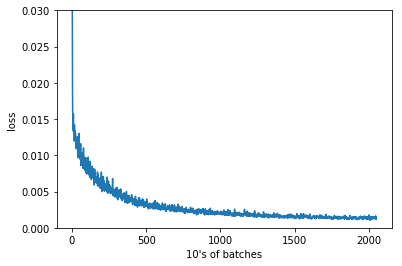

Minimum loss 0.0010337081039324403


In [18]:
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 0.03) # consistent scale
plt.show()
print("Minimum loss", min(training_loss))

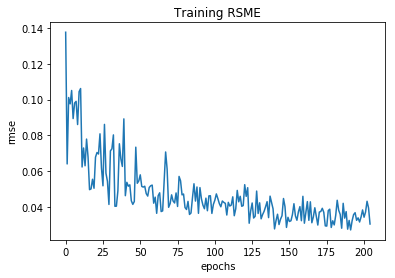

Minimum train RSME 0.0271993530437


In [19]:
plt.plot(t_rmse)
plt.title('Training RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Minimum train RSME", min(t_rmse))

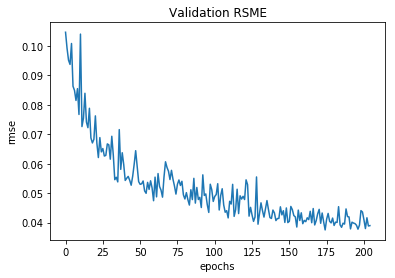

Minimum valid RSME 0.0375110760953


In [20]:
plt.plot(v_rmse)
plt.title('Validation RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Minimum valid RSME", min(v_rmse))

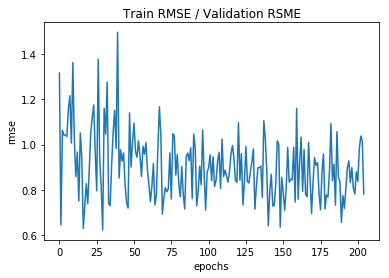

Last T/V quotient 0.782559588399


In [21]:
quotient = np.array(t_rmse) / np.array(v_rmse)
plt.plot(quotient)
plt.title('Train RMSE / Validation RSME')
plt.xlabel('epochs')
plt.ylabel('rmse')
plt.show()
print("Last T/V quotient", quotient[-1])

In [22]:
# get a sample of test data again
net.load_state_dict(torch.load('saved_models/checkpoint.pt'))
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 96, 96])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


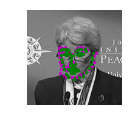

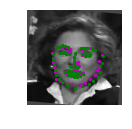

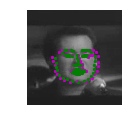

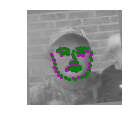

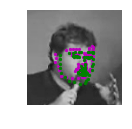

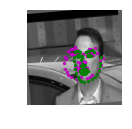

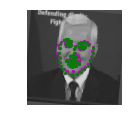

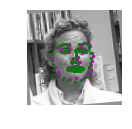

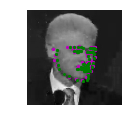

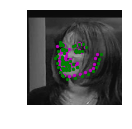

In [24]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [45]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_96x96_VFlip_CR_Rot_B36.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!